In [1]:
%load_ext autoreload
%autoreload 2

In [27]:
import os
import sys
sys.path.insert(0,'/home/djl34/kl_git/scripts')
from notebook_imports import *

import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import glob
import raklette
from run_raklette import TSVDataset, get_neutral_sfs

import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.nn import PyroModule

from raklette import raklette_NN_1layer#, raklette_NN_2layer
import plotly.express as px


# Functions

# Running

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
n_covs = 2
cov_sigma_prior = torch.tensor(0.1, dtype=torch.float32)
num_epochs = 2

lr = 0.1
gamma = 0.5
mu_col = 0
bin_col = 1
cov_col = 2

In [5]:
header = "/n/scratch/users/d/djl34/kl_input/phylop/phastcons_primates_"
chunksize = 1000000
# chrom = None
chrom = 22
dataset = TSVDataset(header = header, chunksize=chunksize, chrom = chrom, device = device)
loader = DataLoader(dataset, batch_size=1, num_workers=1, shuffle=True)

In [6]:
neutral_sfs_filename = os.path.join(KL_data_dir, "whole_genome/freq_bins/freq_bin_9_all.tsv")

n_bins, neutral_sfs = get_neutral_sfs(neutral_sfs_filename, device = device)

number of bins: 8


In [17]:
n_covs = 2
cov_col = 2

KL = raklette.raklette_NN_2layer(neutral_sfs, n_bins, n_covs, n_hidden = 2, device = device)
# KL = raklette.raklette_neuralnet(neutral_sfs, n_bins, n_covs, device)

model = KL.model
guide = pyro.infer.autoguide.AutoNormal(model)

#run inference
pyro.clear_param_store()

num_steps = num_epochs * len(loader)
lrd = gamma ** (1 / num_steps)

# run SVI
optimizer = pyro.optim.ClippedAdam({"lr":lr, 'lrd': lrd})
#     optimizer = pyro.optim.Adam({"lr":lr})
elbo = pyro.infer.Trace_ELBO(num_particles=1, vectorize_particles=True)
svi = pyro.infer.SVI(model, guide, optimizer, elbo)

losses = []
divide_by = 1

In [18]:
print_loss = True
log_freq = 10

for epoch in range(num_epochs):
    progress_bar = tqdm(loader, desc=f'Epoch {epoch+1}/{num_epochs}')
    
    for i, data in enumerate(progress_bar):            
        ## changing values into tensor format

        mu_vals = data[:,:,mu_col].reshape(-1)
        mu_vals = mu_vals.type(torch.LongTensor)
        

        freq_bins = data[:,:,bin_col].reshape(-1)

        if n_covs == 1:
            covariate_vals = torch.squeeze(data[:,:,cov_col:]).unsqueeze(-1)
        else:
            covariate_vals = torch.squeeze(data[:,:,cov_col:])
            
        covariate_vals = covariate_vals.type(torch.FloatTensor)

        loss = svi.step(mu_vals.to(device), covariate_vals.to(device), freq_bins.to(device))
        normalized_loss = loss/data.shape[1]

        # Update the progress bar with the current loss
        progress_bar.set_postfix({'loss': normalized_loss})

        losses.append(normalized_loss)
        

Epoch 2/2: 100%|████████████████████████████████████████████████████████| 83/83 [00:28<00:00,  2.87it/s, loss=0.567]


In [19]:
sfs_pred = model(mu_vals.to(device), covariate_vals.to(device)).detach()

In [20]:
df = pd.DataFrame(sfs_pred.cpu().squeeze().numpy())

In [21]:
df["mu_index"] = mu_vals.cpu().numpy()


In [22]:
df["phastcons"] = covariate_vals[:, 0]

In [23]:
df["sum_p"] = covariate_vals[:, 1]

In [24]:
df

,0,1,2,3,4,5,6,7,8,mu_index,phastcons,sum_p
0,0.868290,0.068183,0.020047,0.015007,0.019405,0.004142,0.003332,0.000916,0.000678,5,0.022,0.979747
1,0.954059,0.025008,0.006657,0.004995,0.006340,0.001327,0.001082,0.000299,0.000232,1,0.022,0.979747
2,0.805517,0.096852,0.030292,0.023043,0.029992,0.006468,0.005285,0.001462,0.001087,8,0.025,0.979747
3,0.954073,0.024998,0.006656,0.004995,0.006340,0.001326,0.001081,0.000299,0.000231,1,0.025,0.979747
4,0.912546,0.045956,0.013274,0.009924,0.012500,0.002670,0.002119,0.000585,0.000426,3,0.025,0.979747
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0.831708,0.081348,0.025438,0.019709,0.027007,0.006224,0.005288,0.001806,0.001473,5,0.005,-0.706660
999996,0.686348,0.138994,0.049081,0.039446,0.055014,0.012910,0.011139,0.003957,0.003111,11,0.005,-0.706660
999997,0.886786,0.055647,0.017091,0.013225,0.017649,0.004071,0.003414,0.001174,0.000942,3,0.005,-0.706660
999998,0.831708,0.081348,0.025438,0.019709,0.027007,0.006224,0.005288,0.001806,0.001473,5,0.005,-0.706660


Text(0, 0.5, 'Monomorphic Proportion')

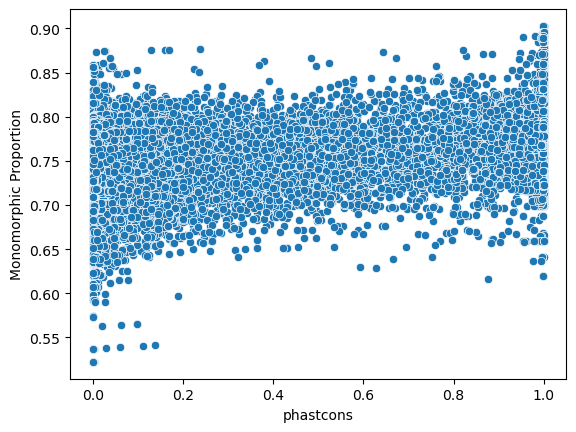

In [71]:
df_plot = df[df["mu_index"] == 10]

sns.scatterplot(data=df_plot, x="phastcons", y=0)
plt.ylabel('Monomorphic Proportion')

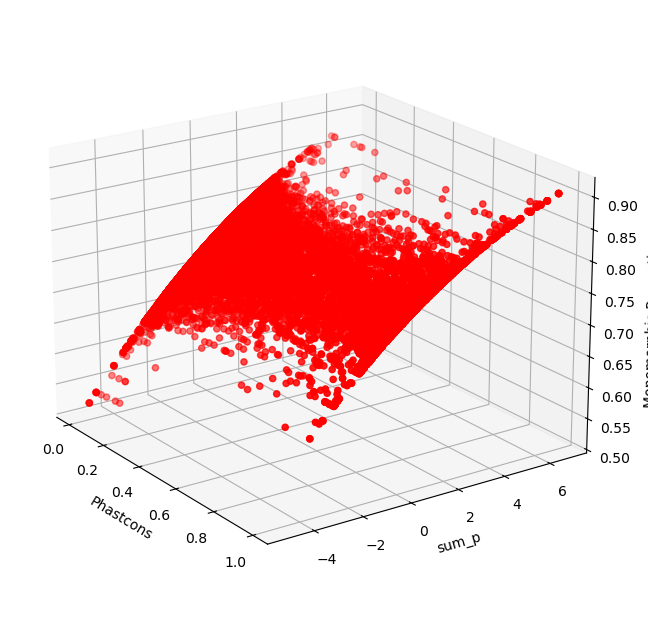

In [66]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=20., azim=-35, roll=0)
# Plot the data
ax.scatter(df_plot['phastcons'], df_plot['sum_p'], df_plot[0], c='r', marker='o')

# Set labels
ax.set_xlabel('Phastcons')
ax.set_ylabel('sum_p')
ax.set_zlabel('Monomorphic Proportion')

plt.subplots_adjust(left=0.0, right=1.0, top=1.0, bottom=0.0)
plt.show()


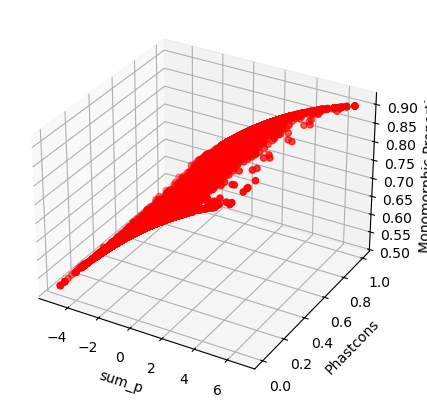

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data
ax.scatter(df_plot['sum_p'], df_plot['phastcons'], df_plot[0], c='r', marker='o')

# Set labels
ax.set_xlabel('sum_p')
ax.set_ylabel('Phastcons')
ax.set_zlabel('Monomorphic Proportion')

fig.subplots_adjust(left=0.0, right=0.9, top=0.9, bottom=0.1)
plt.show()